In [2]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Define Data

In [3]:
df = pd.read_csv('../project_2/catdogdata.txt', delimiter = ' ')



df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries


df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096,label
1,23,23,20,20,9,9,9,4,4,4,...,108,108,108,89,65,51,31,23,9,0
2,250,250,250,244,244,244,244,244,232,232,...,244,244,232,244,244,244,244,232,244,0
3,137,137,137,144,151,151,151,158,151,151,...,89,89,78,78,78,100,102,124,124,0
4,55,55,55,55,55,55,55,55,55,55,...,45,45,45,45,45,45,37,45,52,0
5,173,173,173,173,158,158,158,158,153,149,...,64,64,48,48,77,98,64,45,45,0


In [4]:
def plot_examples(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((64, 64))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

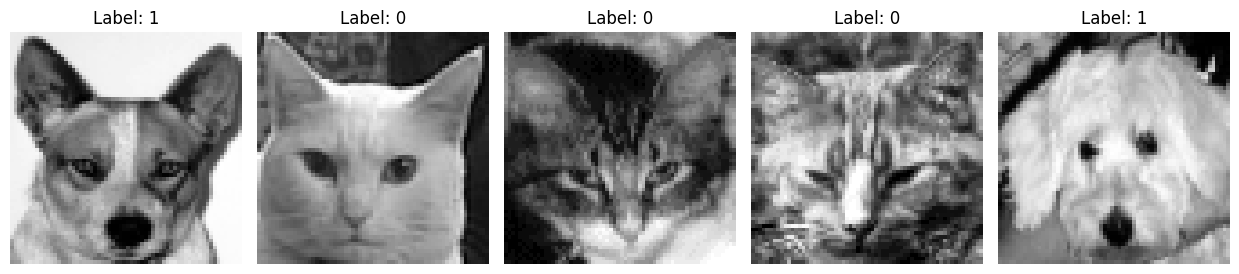

In [5]:
# Rotate all images 90 degrees clockwise
def rotate_image(image):
    return np.rot90(image.reshape(64, 64), -1).flatten()

# Apply the rotation to all rows and update the DataFrame
rotated_images = np.array([rotate_image(row.values) for _, row in df.iloc[:, :-1].iterrows()])
df.iloc[:, :-1] = rotated_images

# plot example images after rotation
plot_examples(df, n=5)

In [142]:
df_mnist = pd.read_csv('../project_2/Numbers.txt', delimiter=' ')

# first column is the label
df_mnist['label'] = df_mnist.iloc[:, 0]
df_mnist = df_mnist.iloc[:, 1:]
X_mnist = df_mnist.iloc[:, :-1].values
y_mnist = df_mnist.iloc[:, -1].values


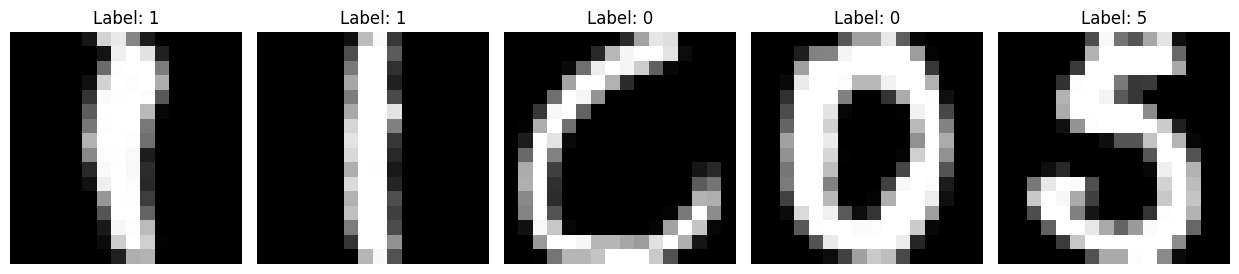

In [9]:
# create a function to plot examples
def plot_examples_mnist(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((16, 16))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
# plot example images
plot_examples_mnist(df_mnist, n=5)

# Make a low dimensional representation

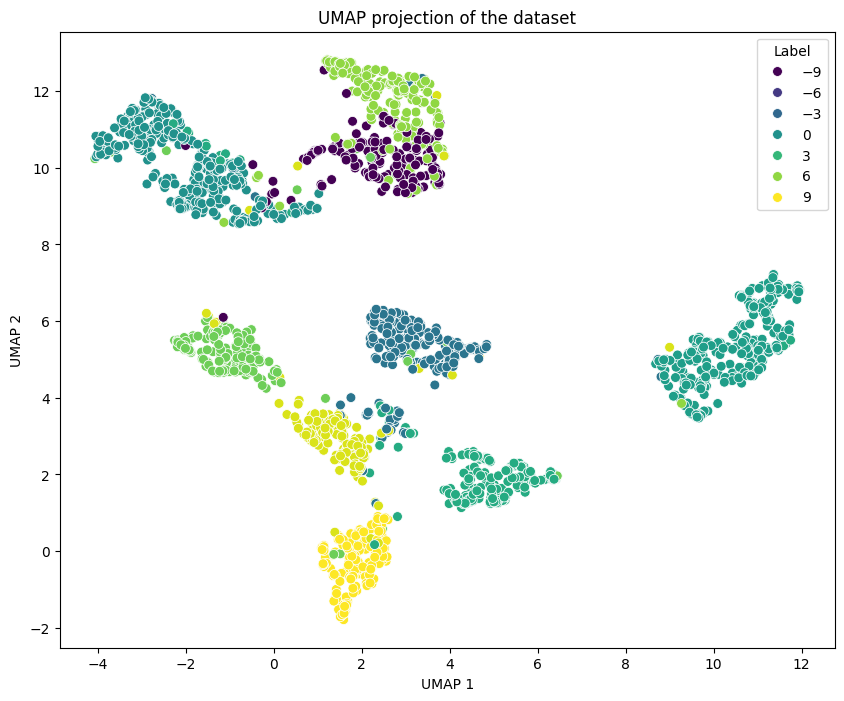

In [60]:
# Use UMAP to create a low-dimensional representation of the data
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df is your DataFrame and the last column is the label
X = df_mnist.iloc[:, :-1].values
y = df_mnist.iloc[:, -1].values
# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2)

# Fit and transform the data
X_umap = umap_model.fit_transform(X)

# Plot the UMAP representation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', s=50)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label')
plt.show()

In [99]:
from sklearn.metrics import davies_bouldin_score

def dbscan_CVinnerloop(eps_grid, min_samples_grid, X_umap, y, mode='silhouette'):
    """
    Perform DBSCAN clustering with cross-validation to find the best parameters.
    Returns the best parameters, best score, and the cluster labels using the best model on the full dataset.
    """
    import numpy as np
    from sklearn.cluster import DBSCAN
    from sklearn.metrics import silhouette_score
    from sklearn.model_selection import KFold

    best_score = -np.inf
    best_params = None
    best_labels = None

    # Create a KFold object for cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for eps in eps_grid:
        for min_samples in min_samples_grid:
            scores = []
            for train_index, test_index in kf.split(X_umap):
                X_train = X_umap[train_index]

                # Apply DBSCAN
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                dbscan.fit(X_train)

                if mode == 'silhouette':
                    if len(set(dbscan.labels_)) > 1:
                        score = silhouette_score(X_train, dbscan.labels_)
                        scores.append(score)

                elif mode == 'dbi':
                    labels = dbscan.labels_
                    if len(set(labels)) > 1 and len(set(labels)) != 1 + (-1 in labels):
                        score = -davies_bouldin_score(X_train, labels)
                        scores.append(score)

                else:
                    raise ValueError("Invalid mode. Choose 'silhouette' or 'dbi'.")

            if scores:
                mean_score = np.mean(scores)
                if mean_score > best_score:
                    best_score = mean_score
                    best_params = (eps, min_samples)

    # Fit the best model on the full dataset
    if best_params:
        best_dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
        best_dbscan.fit(X_umap)
        best_labels = best_dbscan.labels_

    return best_params, best_score, best_labels


def dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode='silhouette'):
    """
    Perform DBSCAN CV outer loop to find stability of running inner loop multiple times.
    Returns best parameters, scores, labels, and stability metrics (ARI/NMI matrices).
    Also plots the resulting clusters for each run.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    best_params_list = []
    best_scores_list = []
    best_labels_list = []

    for run in range(num_runs):
        best_params, best_score, best_labels = dbscan_CVinnerloop(
            eps_grid, min_samples_grid, X_umap, y, mode = mode
        )
        best_params_list.append(best_params)
        best_scores_list.append(best_score)
        best_labels_list.append(best_labels)

    # Compute ARI and NMI matrices
    ari_matrix = np.zeros((num_runs, num_runs))
    nmi_matrix = np.zeros((num_runs, num_runs))

    for i in range(num_runs):
        for j in range(num_runs):
            if i != j:
                ari_matrix[i, j] = adjusted_rand_score(best_labels_list[i], best_labels_list[j])
                nmi_matrix[i, j] = normalized_mutual_info_score(best_labels_list[i], best_labels_list[j])
            else:
                ari_matrix[i, j] = 1.0
                nmi_matrix[i, j] = 1.0

    # Plot clusters from each run
    fig, axes = plt.subplots(1, num_runs, figsize=(5 * num_runs, 4), squeeze=False)
    for i, labels in enumerate(best_labels_list):
        ax = axes[0][i]
        scatter = ax.scatter(
            X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=10
        )
        ax.set_title(f'Run {i+1}\nParams: eps = {best_params_list[i][1]} min_samples = {best_params_list[i][0]}')
        ax.set_xlabel('UMAP-1')
        ax.set_ylabel('UMAP-2')
    plt.tight_layout()
    plt.show()

    return {
        "best_params_list": best_params_list,
        "best_scores_list": best_scores_list,
        "best_labels_list": best_labels_list,
        "ari_matrix": ari_matrix,
        "nmi_matrix": nmi_matrix,
    }


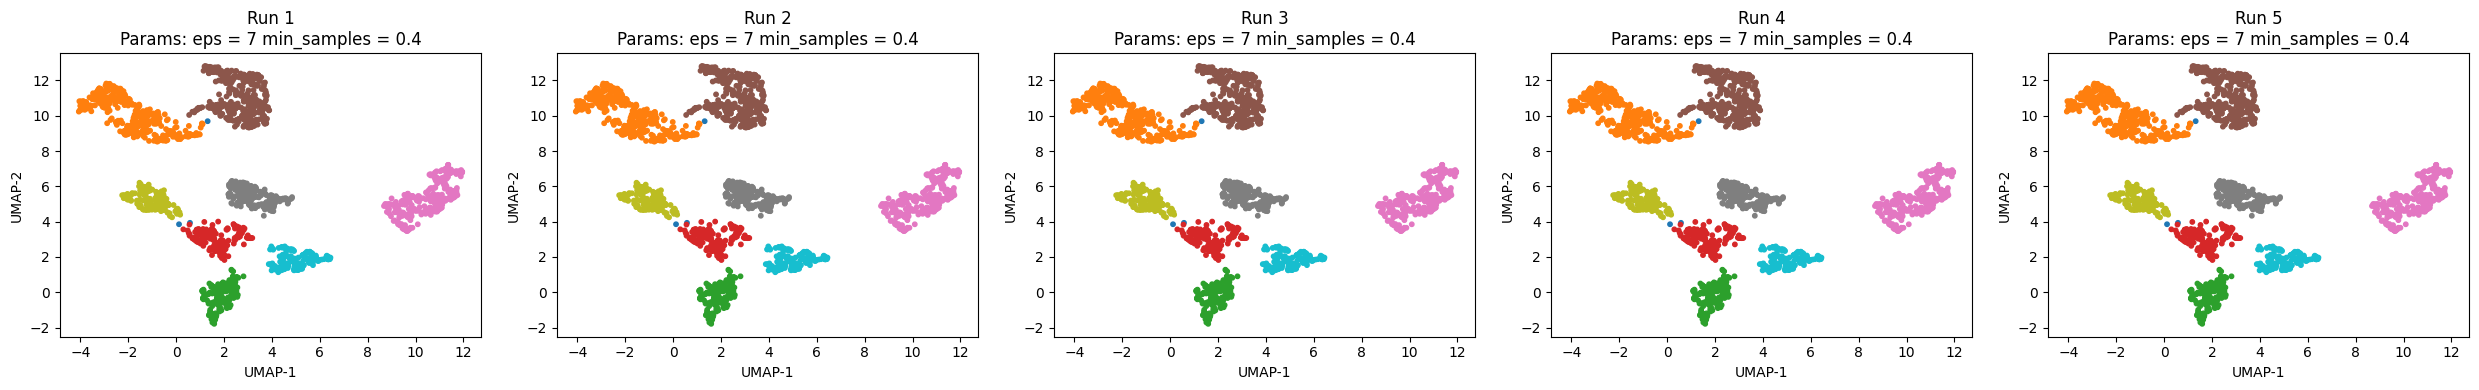

ARI: 1.0
NMI: 1.0


In [100]:
eps_grid = np.arange(0.1, 1.0, 0.1)
min_samples_grid = np.arange(1, 10, 1)
num_runs = 5

results = dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode ='silhouette')
# Extract the ARI and NMI matrices
ari_matrix = results['ari_matrix']
nmi_matrix = results['nmi_matrix']
# Print the ARI and NMI scores
ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
print("ARI:" , ari_matrix_no_diag.mean())
print("NMI:" , nmi_matrix_no_diag.mean())


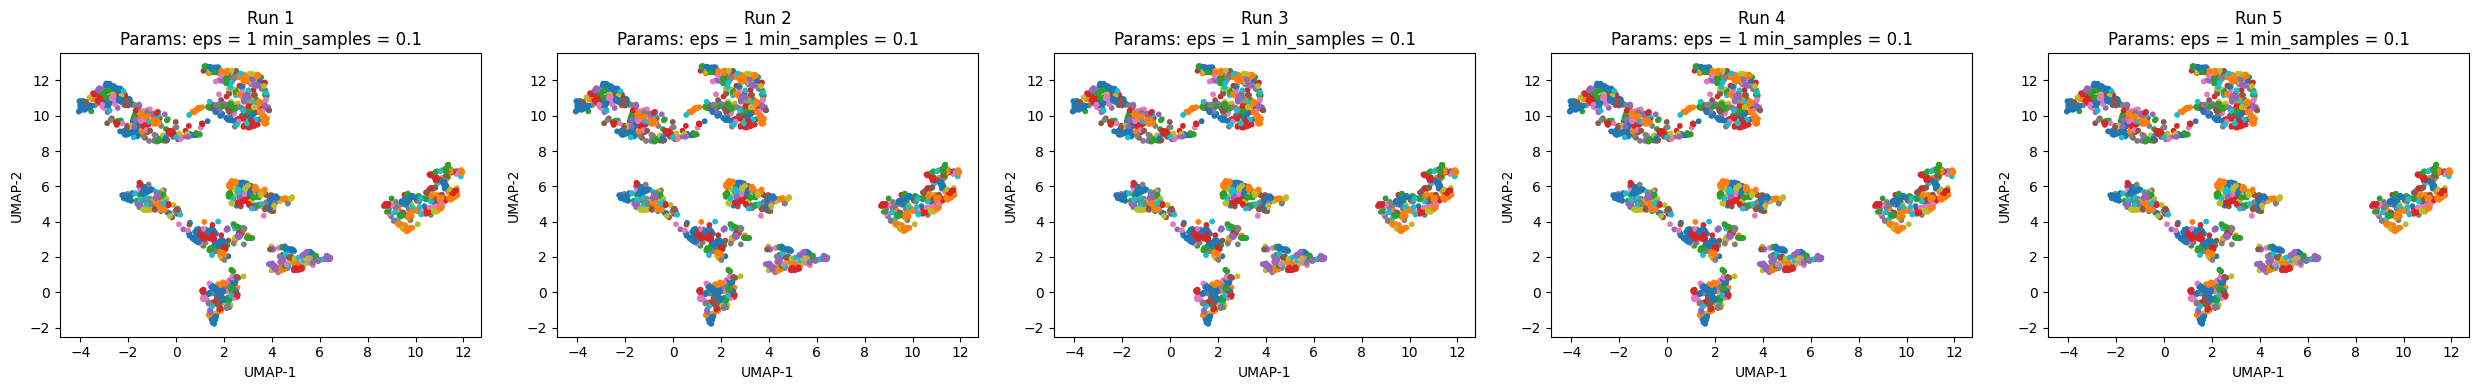

ARI: 1.0
NMI: 1.0


In [101]:
eps_grid = np.arange(0.1, 1.0, 0.1)
min_samples_grid = np.arange(1, 10, 1)
num_runs = 5

results = dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode ='dbi')
# Extract the ARI and NMI matrices
ari_matrix = results['ari_matrix']
nmi_matrix = results['nmi_matrix']

# Print the ARI and NMI scores (removing the diagonal)
ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
print("ARI:" , ari_matrix_no_diag.mean())
print("NMI:" , nmi_matrix_no_diag.mean())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


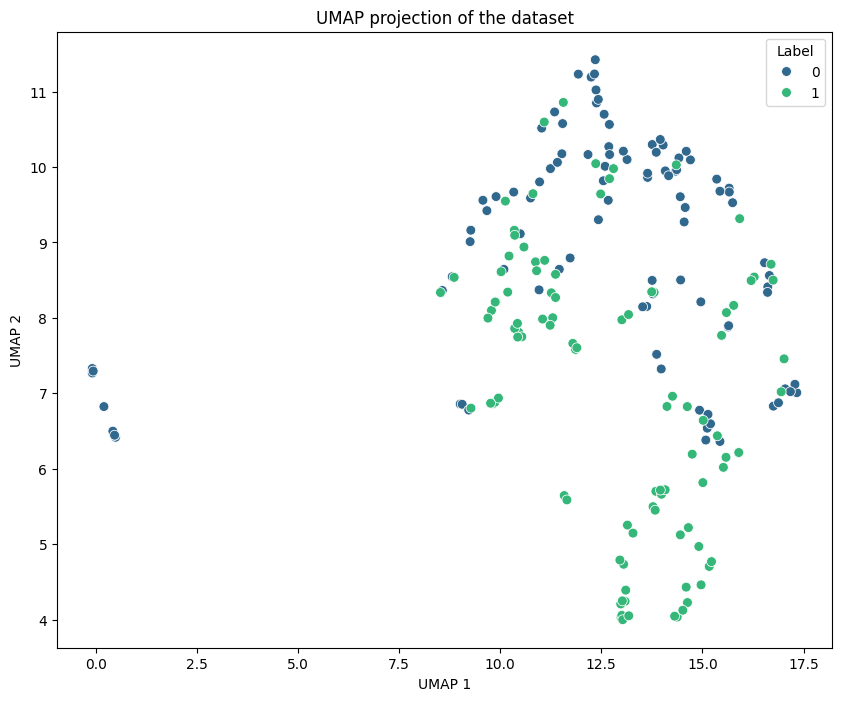

In [139]:
# Now for the cat-dog dataset
# Use UMAP to create a low-dimensional representation of the data

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the data
X_umap = umap_model.fit_transform(X)
# Plot the UMAP representation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', s=50)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label')
plt.show()


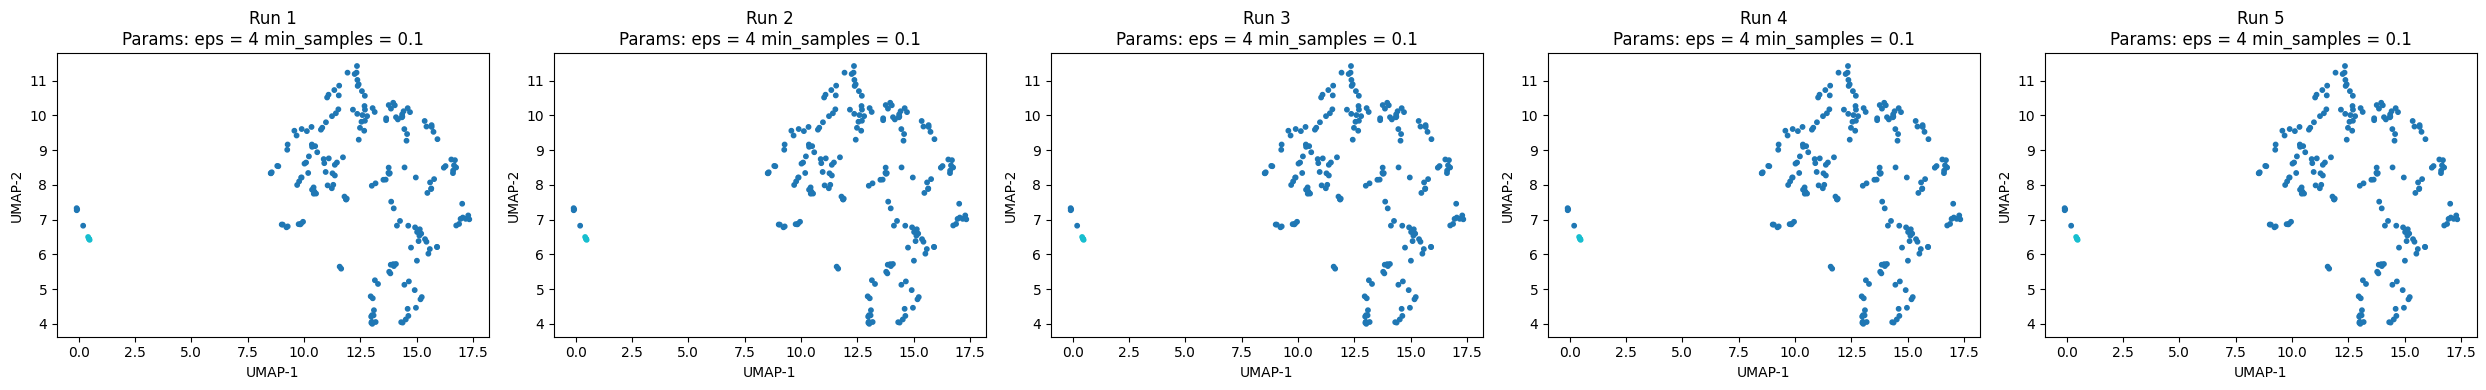

ARI: 1.0
NMI: 1.0


In [140]:
eps_grid = np.arange(0.1, 1.0, 0.1)
min_samples_grid = np.arange(1, 10, 1)
num_runs = 5

results = dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode ='silhouette')
# Extract the ARI and NMI matrices
ari_matrix = results['ari_matrix']
nmi_matrix = results['nmi_matrix']
# Print the ARI and NMI scores
ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
print("ARI:" , ari_matrix_no_diag.mean())
print("NMI:" , nmi_matrix_no_diag.mean())


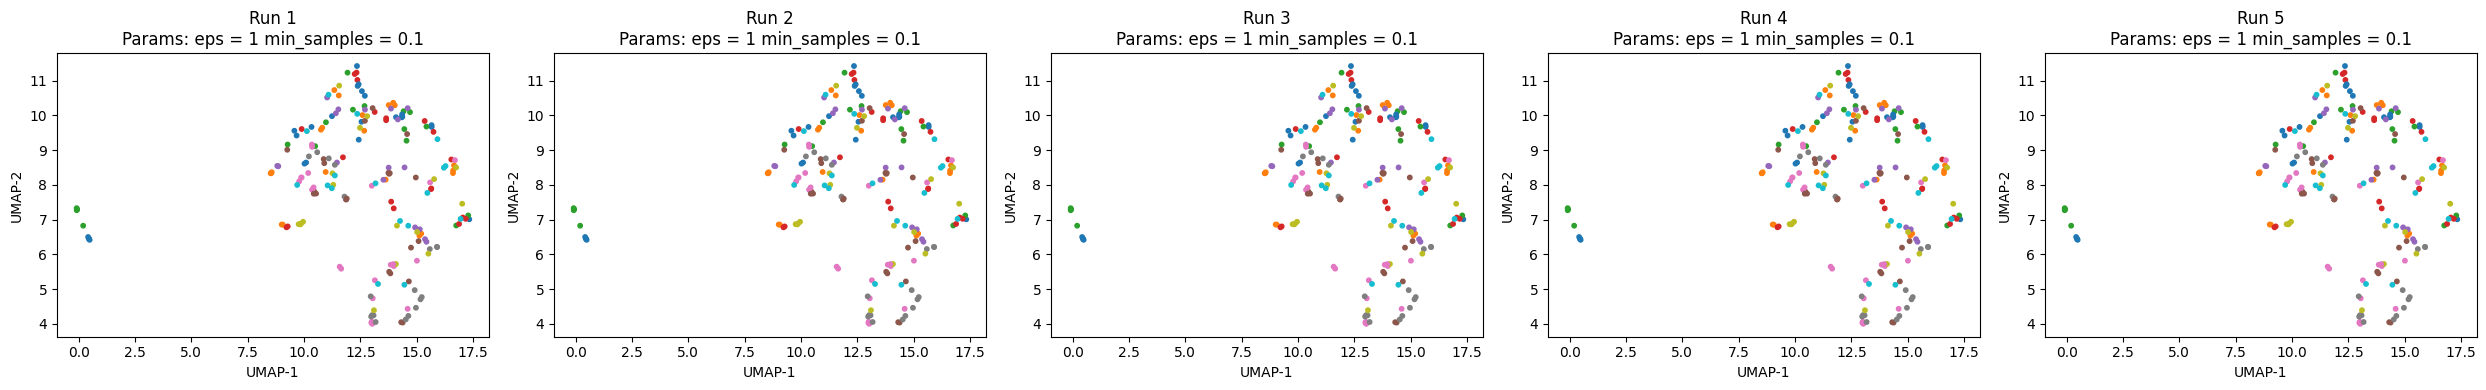

ARI: 1.0
NMI: 1.0


In [141]:
eps_grid = np.arange(0.1, 1.0, 0.1)
min_samples_grid = np.arange(1, 10, 1)
num_runs = 5

results = dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode ='dbi')
# Extract the ARI and NMI matrices
ari_matrix = results['ari_matrix']
nmi_matrix = results['nmi_matrix']

# Print the ARI and NMI scores (removing the diagonal)
ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
print("ARI:" , ari_matrix_no_diag.mean())
print("NMI:" , nmi_matrix_no_diag.mean())


# Part 2 - Theme 1: Imbalance and Sample size

## Sample size changes

In [161]:
# Pick out only digits 0, 1, and 2
df_mnist_shallow = df_mnist[df_mnist['label'].isin([0, 1, 9])]


print("Number of samples in each class:")
print(df_mnist_shallow['label'].value_counts())



Number of samples in each class:
label
0    349
1    307
9    179
Name: count, dtype: int64


/var/folders/1s/z220kbn525j9yjx9gm24pbv40000gn/T/ipykernel_71095/2067842956.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mnist_shallow = df_mnist_shallow.groupby('label').apply(lambda x: x.sample(min_size)).reset_index(drop=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


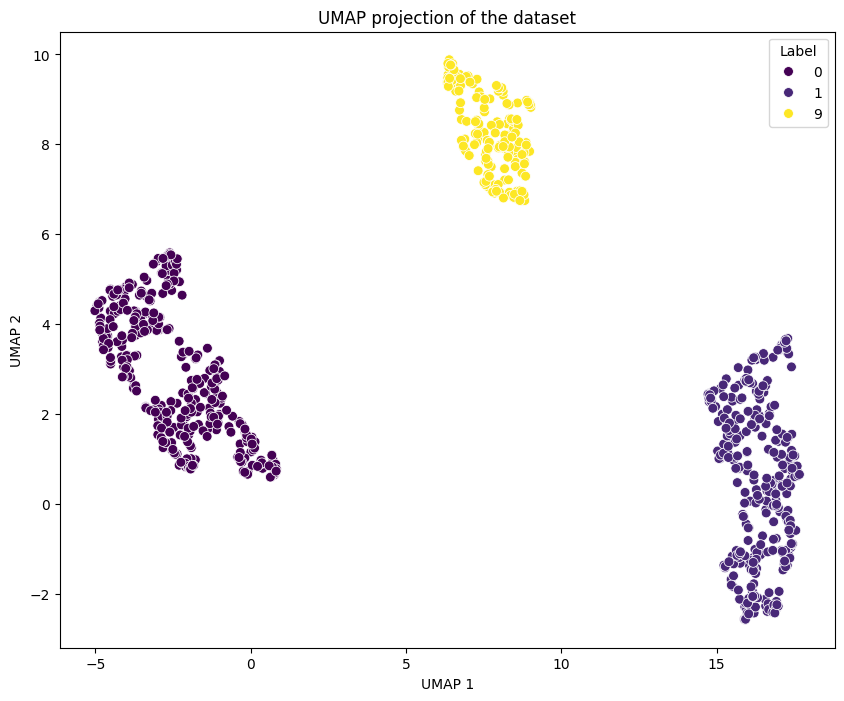

In [162]:
# Use UMAP to create a low-dimensional representation of the data
X = df_mnist_shallow.iloc[:, :-1].values
y = df_mnist_shallow.iloc[:, -1].values

# Make all classes equal size
min_size = min(df_mnist_shallow['label'].value_counts())
df_mnist_shallow = df_mnist_shallow.groupby('label').apply(lambda x: x.sample(min_size)).reset_index(drop=True)

# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the data
X_umap = umap_model.fit_transform(X)

# Plot the UMAP representation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', s=50)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label')
plt.show()

In [163]:
import pandas as pd

def stratified_sample(X_umap, y, sample_size):
    """
    Returns X_sampled, y_sampled with stratified sampling to preserve class balance.
    """
    df = pd.DataFrame(X_umap)
    df['label'] = y
    stratified_df = []

    for label in df['label'].unique():
        class_group = df[df['label'] == label]
        n_samples = int(len(class_group) * sample_size)
        sampled = class_group.sample(n=n_samples, replace=False, random_state=42)
        stratified_df.append(sampled)

    df_sampled = pd.concat(stratified_df).sample(frac=1, random_state=42)  # shuffle
    X_sampled = df_sampled.drop(columns='label').values
    y_sampled = df_sampled['label'].values
    return X_sampled, y_sampled


def dbscan_outerloop_smallersamples(num_runs, sample_size_grid, eps_grid, min_samples_grid, X_umap, y, mode='silhouette'):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    results_per_sample = []

    for sample_size in sample_size_grid:
        best_params_list = []
        best_scores_list = []
        best_labels_list = []

        # Sample once per sample_size (for all runs) keeping the labels even
        X_sampled, y_sampled = stratified_sample(X_umap, y, sample_size)

        for run in range(num_runs):
            best_params, best_score, best_labels = dbscan_CVinnerloop(
                eps_grid, min_samples_grid, X_sampled, y_sampled, mode=mode
            )
            best_params_list.append(best_params)
            best_scores_list.append(best_score)
            best_labels_list.append(best_labels)

        # Compute ARI and NMI matrices
        ari_matrix = np.zeros((num_runs, num_runs))
        nmi_matrix = np.zeros((num_runs, num_runs))

        for i in range(num_runs):
            for j in range(num_runs):
                if i != j:
                    ari_matrix[i, j] = adjusted_rand_score(best_labels_list[i], best_labels_list[j])
                    nmi_matrix[i, j] = normalized_mutual_info_score(best_labels_list[i], best_labels_list[j])
                else:
                    ari_matrix[i, j] = 1.0
                    nmi_matrix[i, j] = 1.0

        # Plot clusters from each run
        fig, axes = plt.subplots(1, num_runs, figsize=(5 * num_runs, 4), squeeze=False)
        for i, labels in enumerate(best_labels_list):
            ax = axes[0][i]
            scatter = ax.scatter(
                X_sampled[:, 0], X_sampled[:, 1], c=labels, cmap='tab10', s=10
            )
            ax.set_title(f'Run {i+1}\nParams: eps={best_params_list[i][0]}, min_samples={best_params_list[i][1]}')
            ax.set_xlabel('UMAP-1')
            ax.set_ylabel('UMAP-2')
        plt.suptitle(f"Sample Size = {int(sample_size * 100)}% of dataset")
        plt.tight_layout()
        plt.show()

        results_per_sample.append({
            "sample_size": sample_size,
            "best_params_list": best_params_list,
            "best_scores_list": best_scores_list,
            "best_labels_list": best_labels_list,
            "ari_matrix": ari_matrix,
            "nmi_matrix": nmi_matrix,
        })

    return results_per_sample


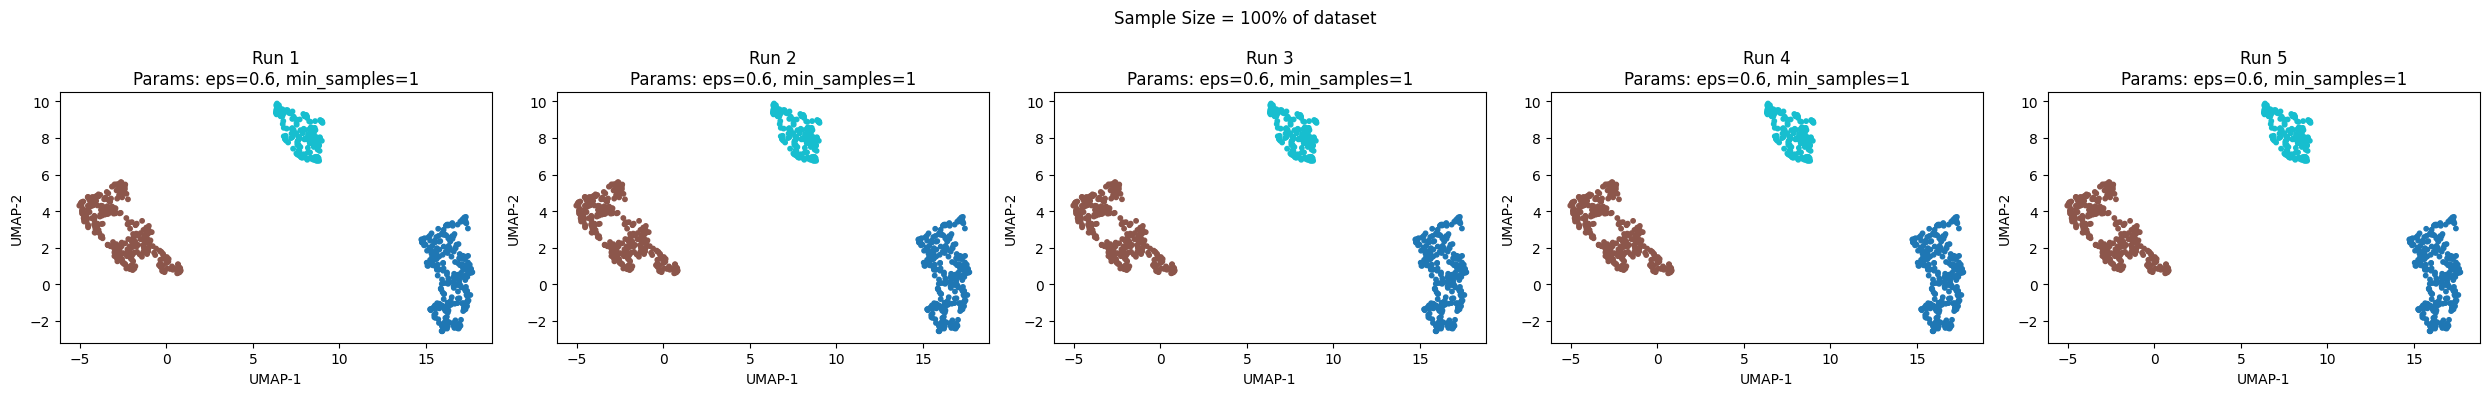

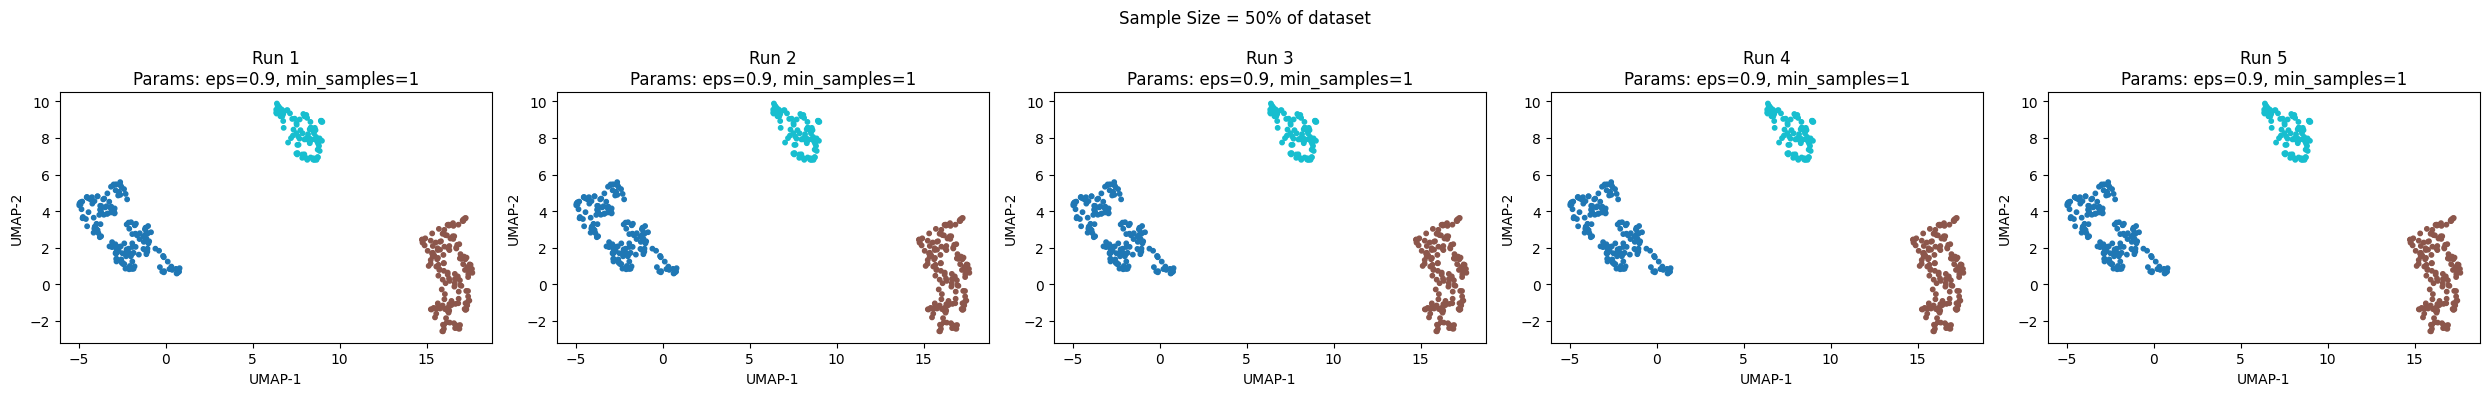

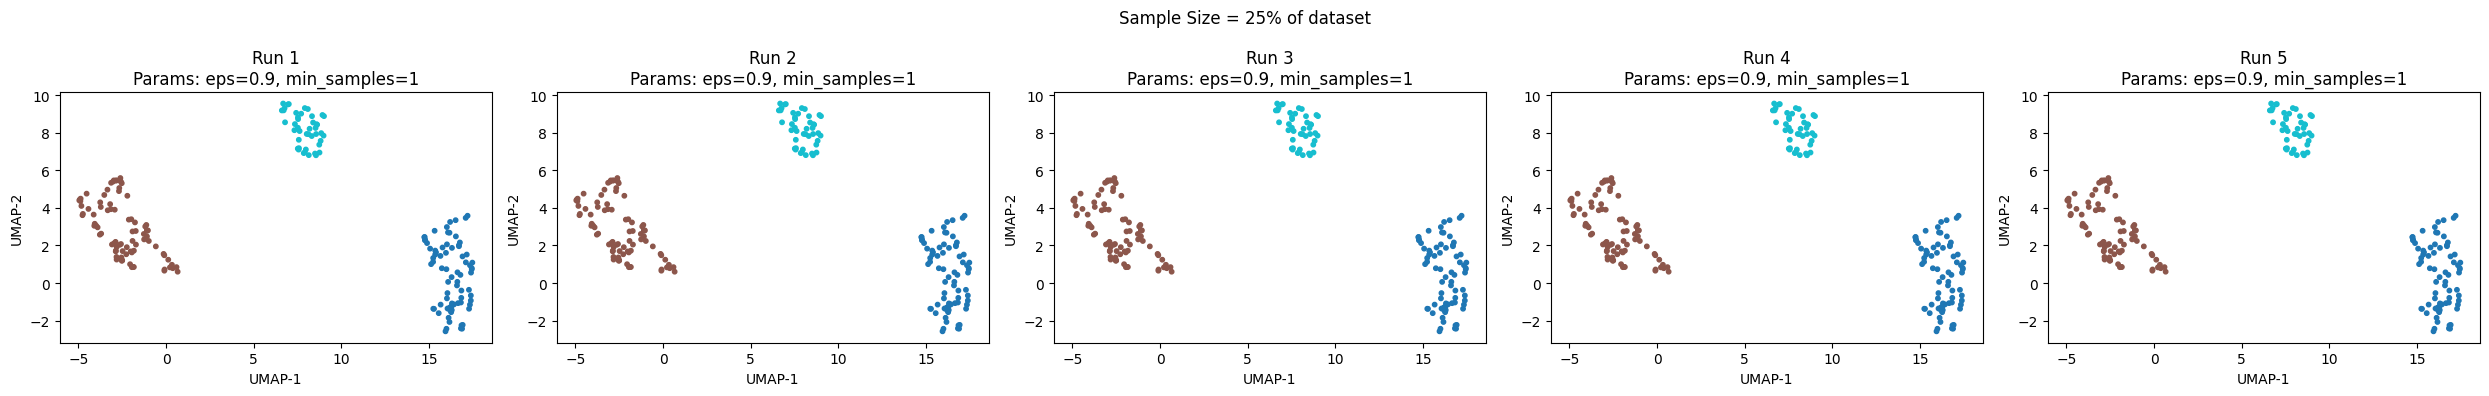

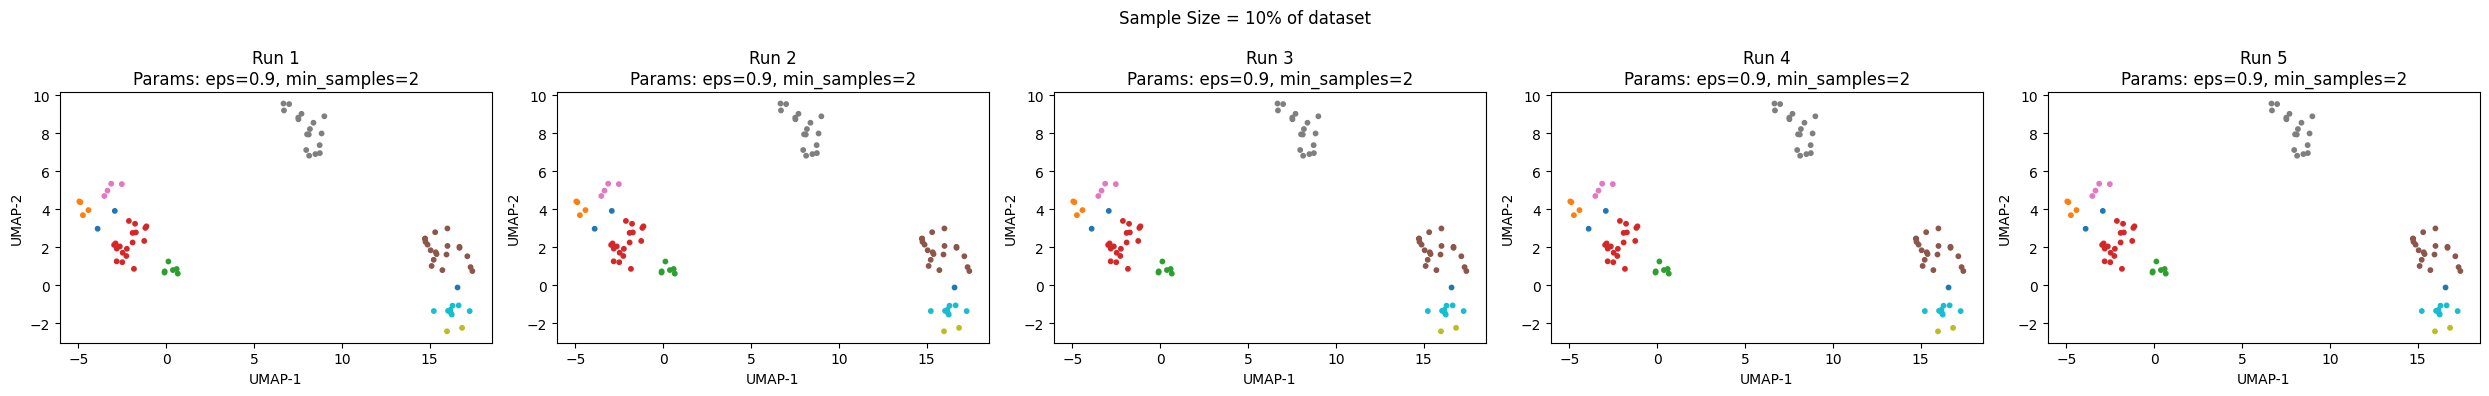

Sample Size 100.0 %:
ARI: 1.0
NMI: 1.0
Sample Size 50.0 %:
ARI: 1.0
NMI: 1.0
Sample Size 25.0 %:
ARI: 1.0
NMI: 1.0
Sample Size 10.0 %:
ARI: 1.0
NMI: 1.0


In [170]:
min_samples_grid = np.arange(1, 10, 1)
eps_grid = np.arange(0.1, 1.0, 0.1)
sample_size_grid = [1.0, 0.5, 0.25, 0.1]  # Sample sizes to test
num_runs = 5
results = dbscan_outerloop_smallersamples(num_runs, sample_size_grid, eps_grid, min_samples_grid, X_umap, y, mode='silhouette')

# Extract the ARI and NMI matrices for each sample size
ari_matrices = [result['ari_matrix'] for result in results]
nmi_matrices = [result['nmi_matrix'] for result in results]

# Print the ARI and NMI scores for each sample size (removing the diagonal)
for i, result in enumerate(results):
    ari_matrix = result['ari_matrix']
    nmi_matrix = result['nmi_matrix']
    
    ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
    nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
    
    print(f"Sample Size {result['sample_size'] * 100} %:")
    print("ARI:", ari_matrix_no_diag.mean())
    print("NMI:", nmi_matrix_no_diag.mean())


## Uneven data

In [171]:
# Pick out only digits 0, 1, and 2
df_mnist_uneven = df_mnist[df_mnist['label'].isin([0, 1, 9])]

print("Number of samples in each class:")
print(df_mnist_uneven['label'].value_counts())


Number of samples in each class:
label
0    349
1    307
9    179
Name: count, dtype: int64


/var/folders/1s/z220kbn525j9yjx9gm24pbv40000gn/T/ipykernel_71095/2475667106.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mnist_uneven = df_mnist_uneven.groupby('label').apply(lambda x: x.sample(min_size)).reset_index(drop=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


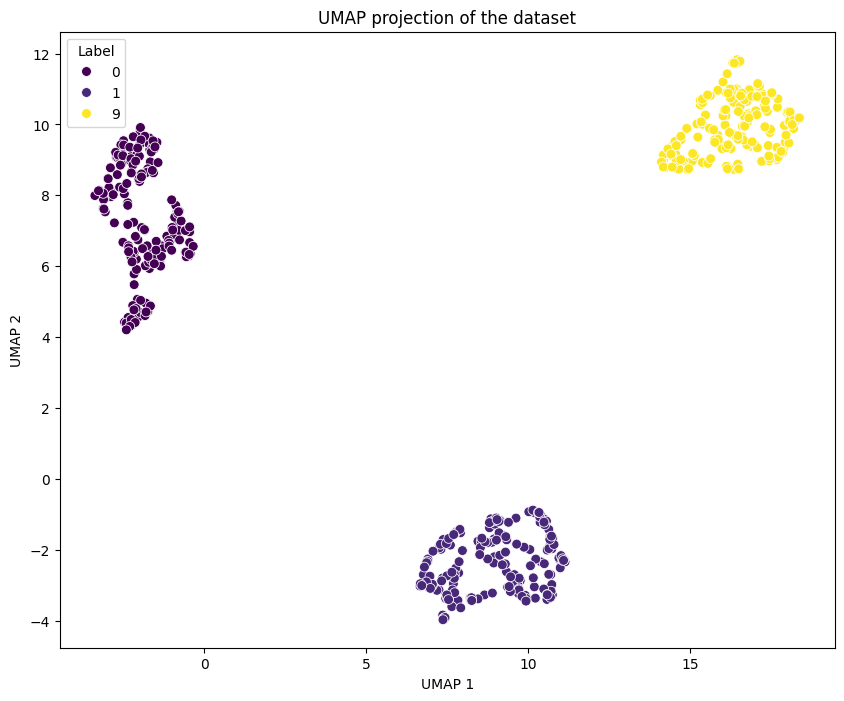

Number of samples in each class:
label
0    179
1    179
9    179
Name: count, dtype: int64


In [186]:
# Use UMAP to create a low-dimensional representation of the data
X = df_mnist_uneven.iloc[:, :-1].values
y = df_mnist_uneven.iloc[:, -1].values

# Make all classes equal size
min_size = min(df_mnist_uneven['label'].value_counts())
df_mnist_uneven = df_mnist_uneven.groupby('label').apply(lambda x: x.sample(min_size)).reset_index(drop=True)

# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the data
X_umap = umap_model.fit_transform(X)

# Plot the UMAP representation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', s=50)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label')
plt.show()

# print the number of samples in each class
print("Number of samples in each class:")
print(df_mnist_uneven['label'].value_counts())

In [179]:
def generate_imbalanced_data(X, y, fixed_sample_size, imbalance_ratio, minority_class):
    """
    Generate a dataset with balanced major classes and a downsampled minority class.
    
    Args:
        X, y: full dataset
        fixed_sample_size: number of samples per majority class
        imbalance_ratio: proportion of minority class relative to majority
        minority_class: class label to downsample
    
    Returns:
        X_sampled, y_sampled
    """


    df = pd.DataFrame(X)
    df['label'] = y
    labels = df['label'].unique()
    
    sampled_parts = []

    for label in labels:
        class_df = df[df['label'] == label]
        if label == minority_class:
            n_samples = max(1, int(fixed_sample_size * imbalance_ratio))
        else:
            n_samples = fixed_sample_size
        sampled = class_df.sample(n=n_samples, replace=(n_samples > len(class_df)), random_state=42)
        sampled_parts.append(sampled)

    df_sampled = pd.concat(sampled_parts).sample(frac=1, random_state=42)
    X_sampled = df_sampled.drop(columns='label').values
    y_sampled = df_sampled['label'].values
    return X_sampled, y_sampled


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def dbscan_outerloop_imbalanced(num_runs, imbalance_ratios, fixed_sample_size, minority_class,
                                 eps_grid, min_samples_grid, X_umap, y, mode='silhouette'):


    results_per_imbalance = []

    for imbalance_ratio in imbalance_ratios:
        best_params_list = []
        best_scores_list = []
        best_labels_list = []

        # Create the imbalanced dataset
        X_sampled, y_sampled = generate_imbalanced_data(
            X_umap, y,
            fixed_sample_size=fixed_sample_size,
            imbalance_ratio=imbalance_ratio,
            minority_class=minority_class
        )

        for run in range(num_runs):
            best_params, best_score, best_labels = dbscan_CVinnerloop(
                eps_grid, min_samples_grid, X_sampled, y_sampled, mode=mode
            )
            best_params_list.append(best_params)
            best_scores_list.append(best_score)
            best_labels_list.append(best_labels)

        # Stability matrices
        ari_matrix = np.zeros((num_runs, num_runs))
        nmi_matrix = np.zeros((num_runs, num_runs))

        for i in range(num_runs):
            for j in range(num_runs):
                if i != j:
                    ari_matrix[i, j] = adjusted_rand_score(best_labels_list[i], best_labels_list[j])
                    nmi_matrix[i, j] = normalized_mutual_info_score(best_labels_list[i], best_labels_list[j])
                else:
                    ari_matrix[i, j] = 1.0
                    nmi_matrix[i, j] = 1.0

        # Plot clusters
        fig, axes = plt.subplots(1, num_runs, figsize=(5 * num_runs, 4), squeeze=False)
        for i, labels in enumerate(best_labels_list):
            ax = axes[0][i]
            ax.scatter(X_sampled[:, 0], X_sampled[:, 1], c=labels, cmap='tab10', s=10)
            ax.set_title(f'Run {i+1}\nParams: eps={best_params_list[i][0]:f.2}, min_samples={best_params_list[i][1]}')
            ax.set_xlabel('UMAP-1')
            ax.set_ylabel('UMAP-2')
        plt.suptitle(f"Imbalance Ratio = {imbalance_ratio} (Minority class: {minority_class})")
        plt.tight_layout()
        plt.show()

        results_per_imbalance.append({
            "imbalance_ratio": imbalance_ratio,
            "best_params_list": best_params_list,
            "best_scores_list": best_scores_list,
            "best_labels_list": best_labels_list,
            "ari_matrix": ari_matrix,
            "nmi_matrix": nmi_matrix,
        })

    return results_per_imbalance


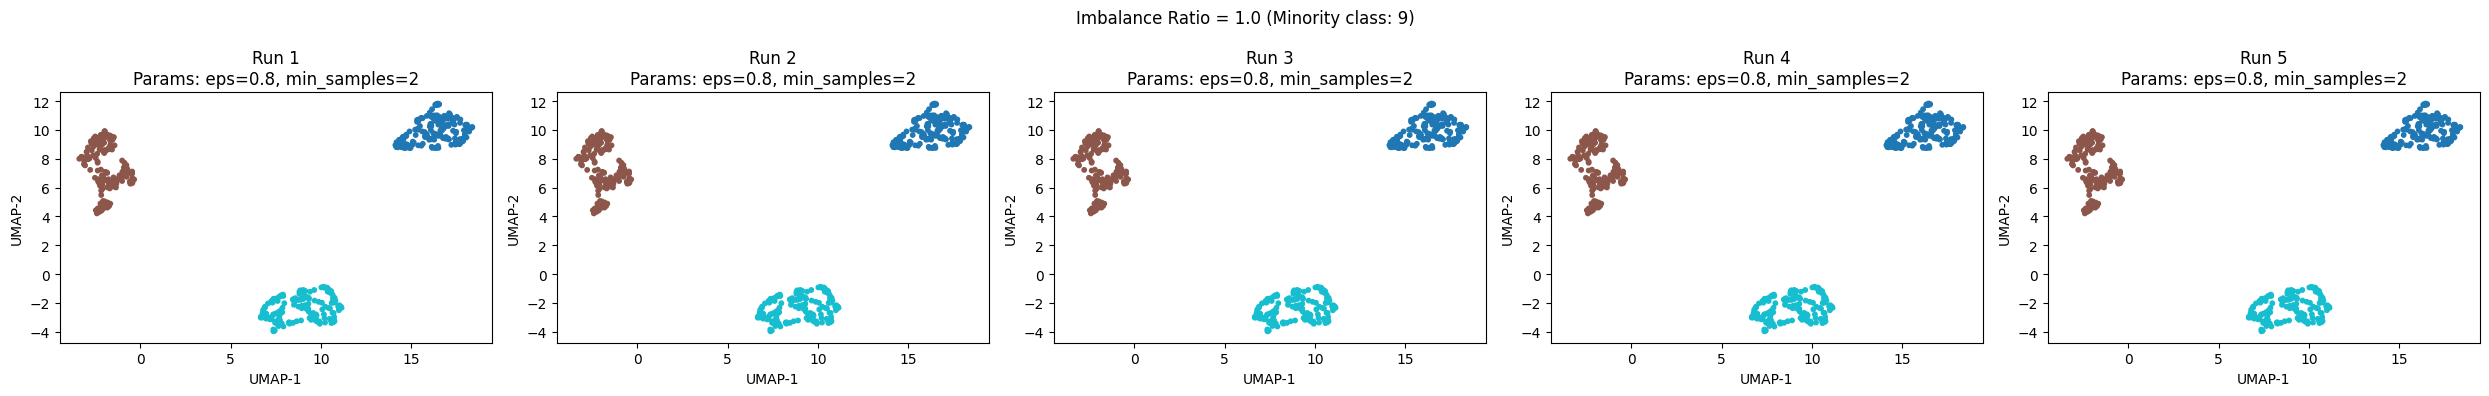

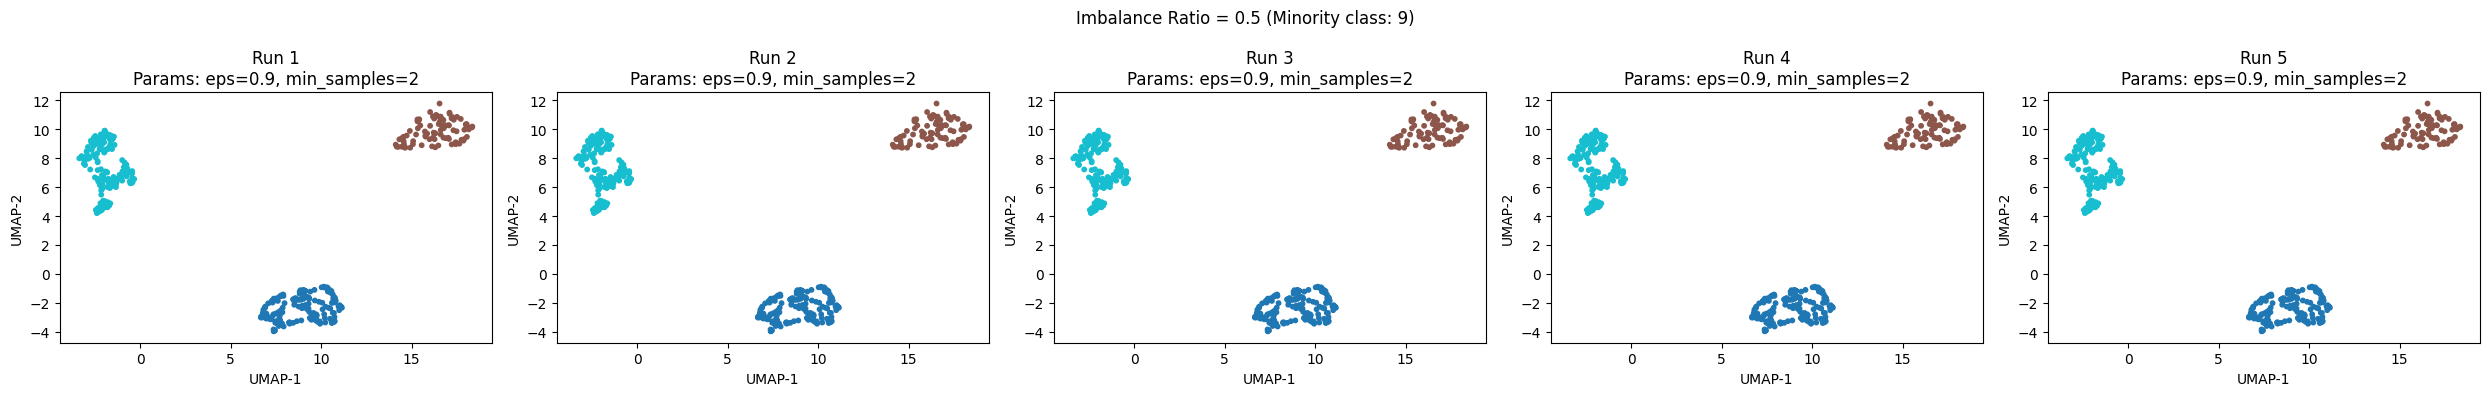

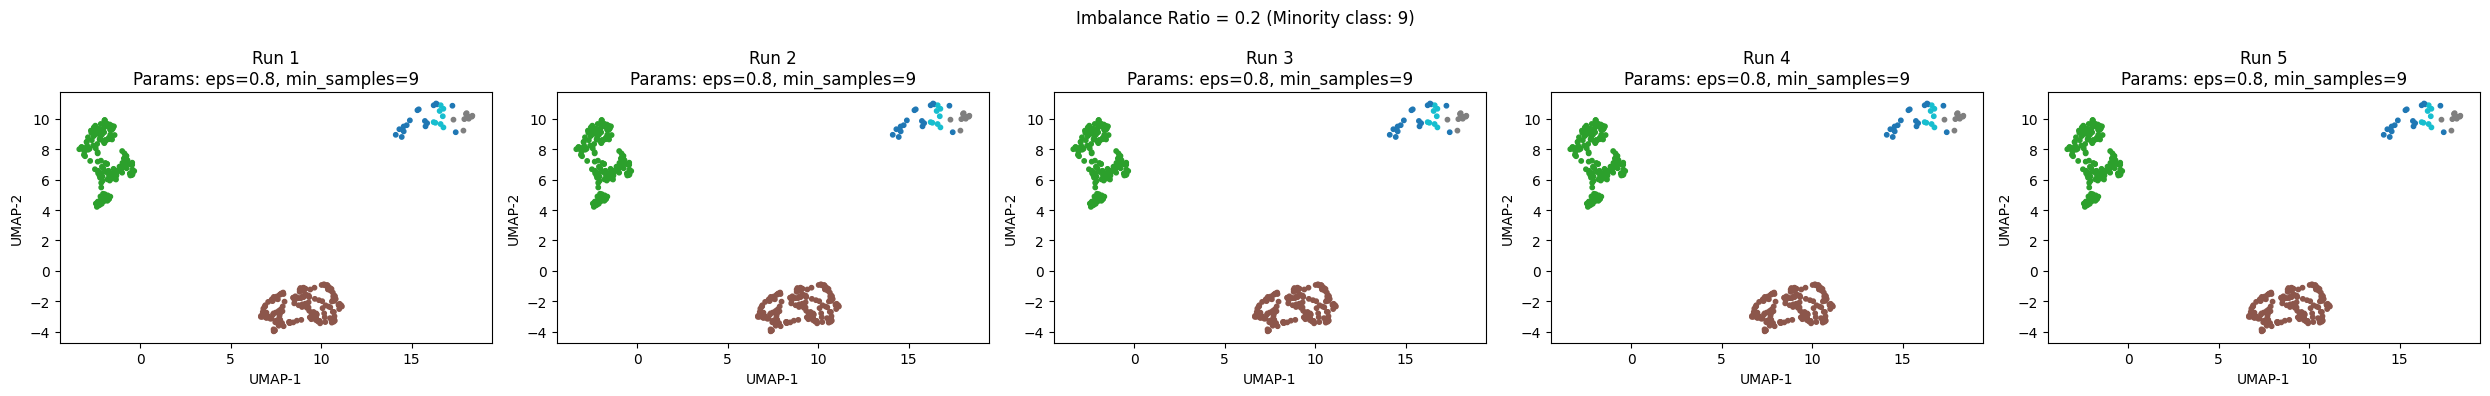

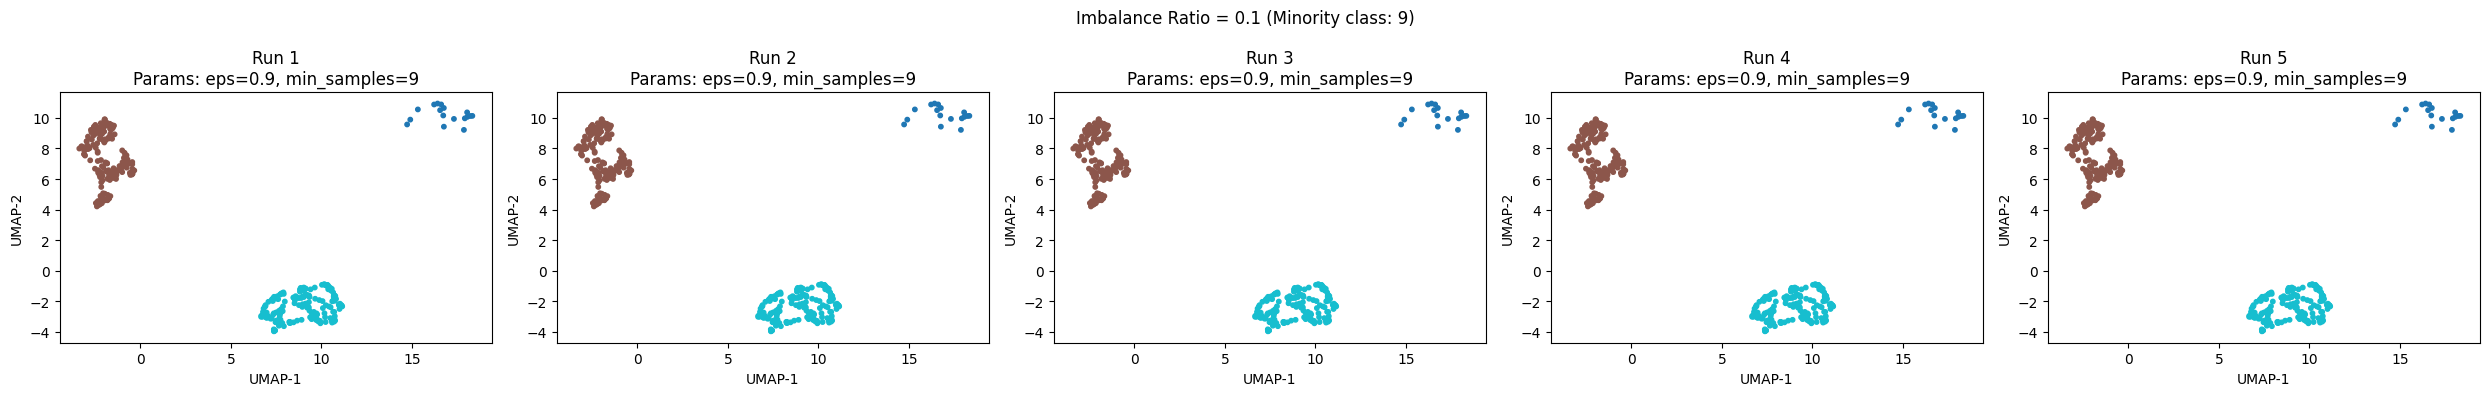

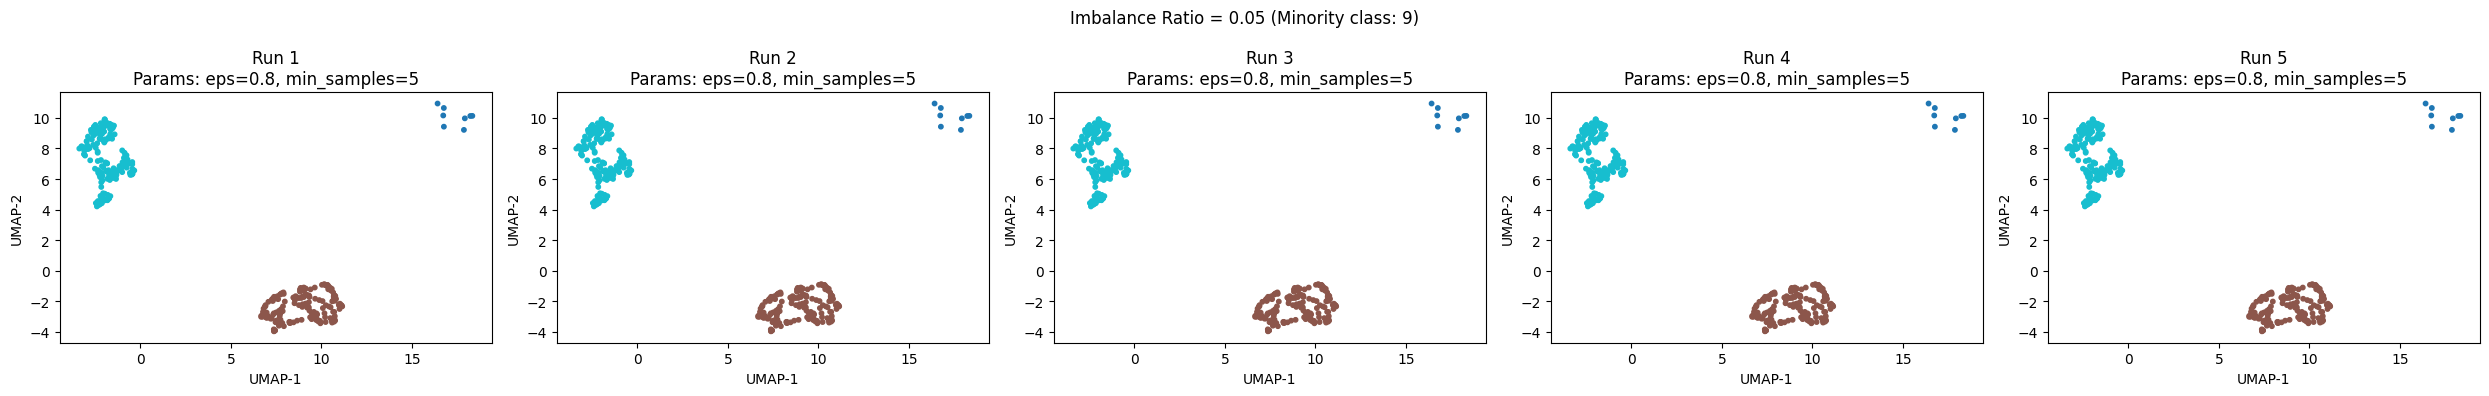

Imbalance Ratio 1.0:
ARI: 1.0
NMI: 1.0
Imbalance Ratio 0.5:
ARI: 1.0
NMI: 1.0
Imbalance Ratio 0.2:
ARI: 1.0
NMI: 1.0
Imbalance Ratio 0.1:
ARI: 1.0
NMI: 1.0
Imbalance Ratio 0.05:
ARI: 1.0
NMI: 1.0


In [188]:
results = dbscan_outerloop_imbalanced(
    num_runs=5,
    imbalance_ratios=[1.0, 0.5, 0.2, 0.1, 0.05],
    fixed_sample_size=179,
    minority_class=9,
    eps_grid=np.arange(0.1, 1.0, 0.1),
    min_samples_grid=np.arange(2, 10),
    X_umap=X_umap,
    y=y,
    mode='silhouette'
)

# Extract the ARI and NMI matrices for each imbalance ratio
ari_matrices = [result['ari_matrix'] for result in results]
nmi_matrices = [result['nmi_matrix'] for result in results]

# Print the ARI and NMI scores for each imbalance ratio (removing the diagonal)
for i, result in enumerate(results):
    ari_matrix = result['ari_matrix']
    nmi_matrix = result['nmi_matrix']
    
    ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
    nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
    
    print(f"Imbalance Ratio {result['imbalance_ratio']}:")
    print("ARI:", ari_matrix_no_diag.mean())
    print("NMI:", nmi_matrix_no_diag.mean())